# Enter the name of your service account JSON file below
# Execute 2 Queries in BigQuery 
# The first query is for the training the model, and the second query for validating the model.

In [42]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
#client = Client()

from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "<YOUR_SERVICE_ACCOUNT_KEY.JSON>"
client = bigquery.Client()


query = """select limit_balance, age, pay_0, pay_2, pay_3, pay_4, 
     bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, 
     pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, 
    cast(default_payment_next_month as int) as default_payment_next_month

from `bigquery-public-data.ml_datasets.credit_card_default`
where id <= 28000"""
job = client.query(query)
df = job.to_dataframe()


query2 = """select limit_balance, age, pay_0, pay_2, pay_3, pay_4, 
     bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, 
     pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, 
    cast(default_payment_next_month as int) as default_payment_next_month

from `bigquery-public-data.ml_datasets.credit_card_default`
where id > 28000"""
job = client.query(query2)
val_df = job.to_dataframe()

# Validate the dataframe that will be used for the Training the model

In [43]:
df.head()

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,default_payment_next_month
0,50000.0,39.0,0.0,0.0,0.0,0.0,47174.0,47974.0,48630.0,50803.0,30789.0,1800.0,2000.0,3000.0,2000.0,2000.0,0
1,110000.0,29.0,0.0,0.0,0.0,0.0,48088.0,45980.0,44231.0,32489.0,26354.0,2000.0,2010.0,3000.0,3000.0,3000.0,0
2,270000.0,36.0,0.0,0.0,0.0,2.0,78630.0,68921.0,46512.0,40335.0,37165.0,10076.0,4018.0,14.0,2051.0,2000.0,0
3,130000.0,45.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,2886.0,2908.0,2129.0,2354.0,2366.0,0
4,50000.0,24.0,0.0,0.0,0.0,0.0,42058.0,35340.0,22110.0,19837.0,19855.0,1367.0,1606.0,692.0,709.0,721.0,0


# Validate the dataframe that will be used for the Validating the model

In [44]:
val_df.head()

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,default_payment_next_month
0,50000.0,42.0,0.0,0.0,0.0,0.0,35892.0,32546.0,30660.0,31320.0,36227.0,2007.0,2000.0,1500.0,5400.0,0.0,0
1,120000.0,32.0,-1.0,0.0,0.0,0.0,66551.0,67876.0,69903.0,71446.0,79589.0,2429.0,3120.0,3300.0,10000.0,3200.0,0
2,40000.0,60.0,0.0,0.0,0.0,0.0,14019.0,15780.0,18519.0,21058.0,8204.0,2000.0,3000.0,3000.0,6000.0,2000.0,0
3,30000.0,30.0,0.0,0.0,0.0,0.0,26061.0,27104.0,28076.0,25991.0,25429.0,1780.0,1752.0,1666.0,800.0,1161.0,0
4,500000.0,39.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,54209.0,4607.0,4603.0,5224.0,207440.0,0


# Import the required packages

In [45]:
from datetime import datetime
import pandas as pd
import tensorflow as tf


In [46]:
df = df.dropna()


# Function to transform the Pandas Dataframe to TensorFlow dataset

In [47]:
def df_to_dataset(dataframe, label, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(label)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Call the above Function to transform the Pandas Dataframe to TensorFlow dataset - once for Training data and other for validation data.

In [48]:
train_data=df_to_dataset(df, 'default_payment_next_month')
val_data=df_to_dataset(val_df, 'default_payment_next_month')


print(train_data)

 

<PrefetchDataset shapes: ({limit_balance: (None,), age: (None,), pay_0: (None,), pay_2: (None,), pay_3: (None,), pay_4: (None,), bill_amt_1: (None,), bill_amt_2: (None,), bill_amt_3: (None,), bill_amt_4: (None,), bill_amt_5: (None,), pay_amt_1: (None,), pay_amt_2: (None,), pay_amt_3: (None,), pay_amt_4: (None,), pay_amt_5: (None,)}, (None,)), types: ({limit_balance: tf.float64, age: tf.float64, pay_0: tf.float64, pay_2: tf.float64, pay_3: tf.float64, pay_4: tf.float64, bill_amt_1: tf.float64, bill_amt_2: tf.float64, bill_amt_3: tf.float64, bill_amt_4: tf.float64, bill_amt_5: tf.float64, pay_amt_1: tf.float64, pay_amt_2: tf.float64, pay_amt_3: tf.float64, pay_amt_4: tf.float64, pay_amt_5: tf.float64}, tf.int64)>


# Look at the features of the training TensorFlow dataset

In [49]:
for feature_batch, label_batch in train_data.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of targets:', label_batch)

Every feature: ['limit_balance', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5']
A batch of targets: tf.Tensor([0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1], shape=(32,), dtype=int64)


# Function to Normalize TensorFlow dataset

In [50]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

# Add a normalization layer to the model one at a time

In [51]:
all_inputs = []
encoded_features = []



for feature_batch, label_batch in train_data.take(1):
   for feat in list(feature_batch.keys()):
        numeric_col = tf.keras.Input(shape=(1,), name=feat)
        normalization_layer = get_normalization_layer(feat, train_data)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

# Define a TensorFlow model

In [52]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

# Compile the TensorFlow model

In [53]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_logarithmic_error')

# Plot the TensorFlow Model

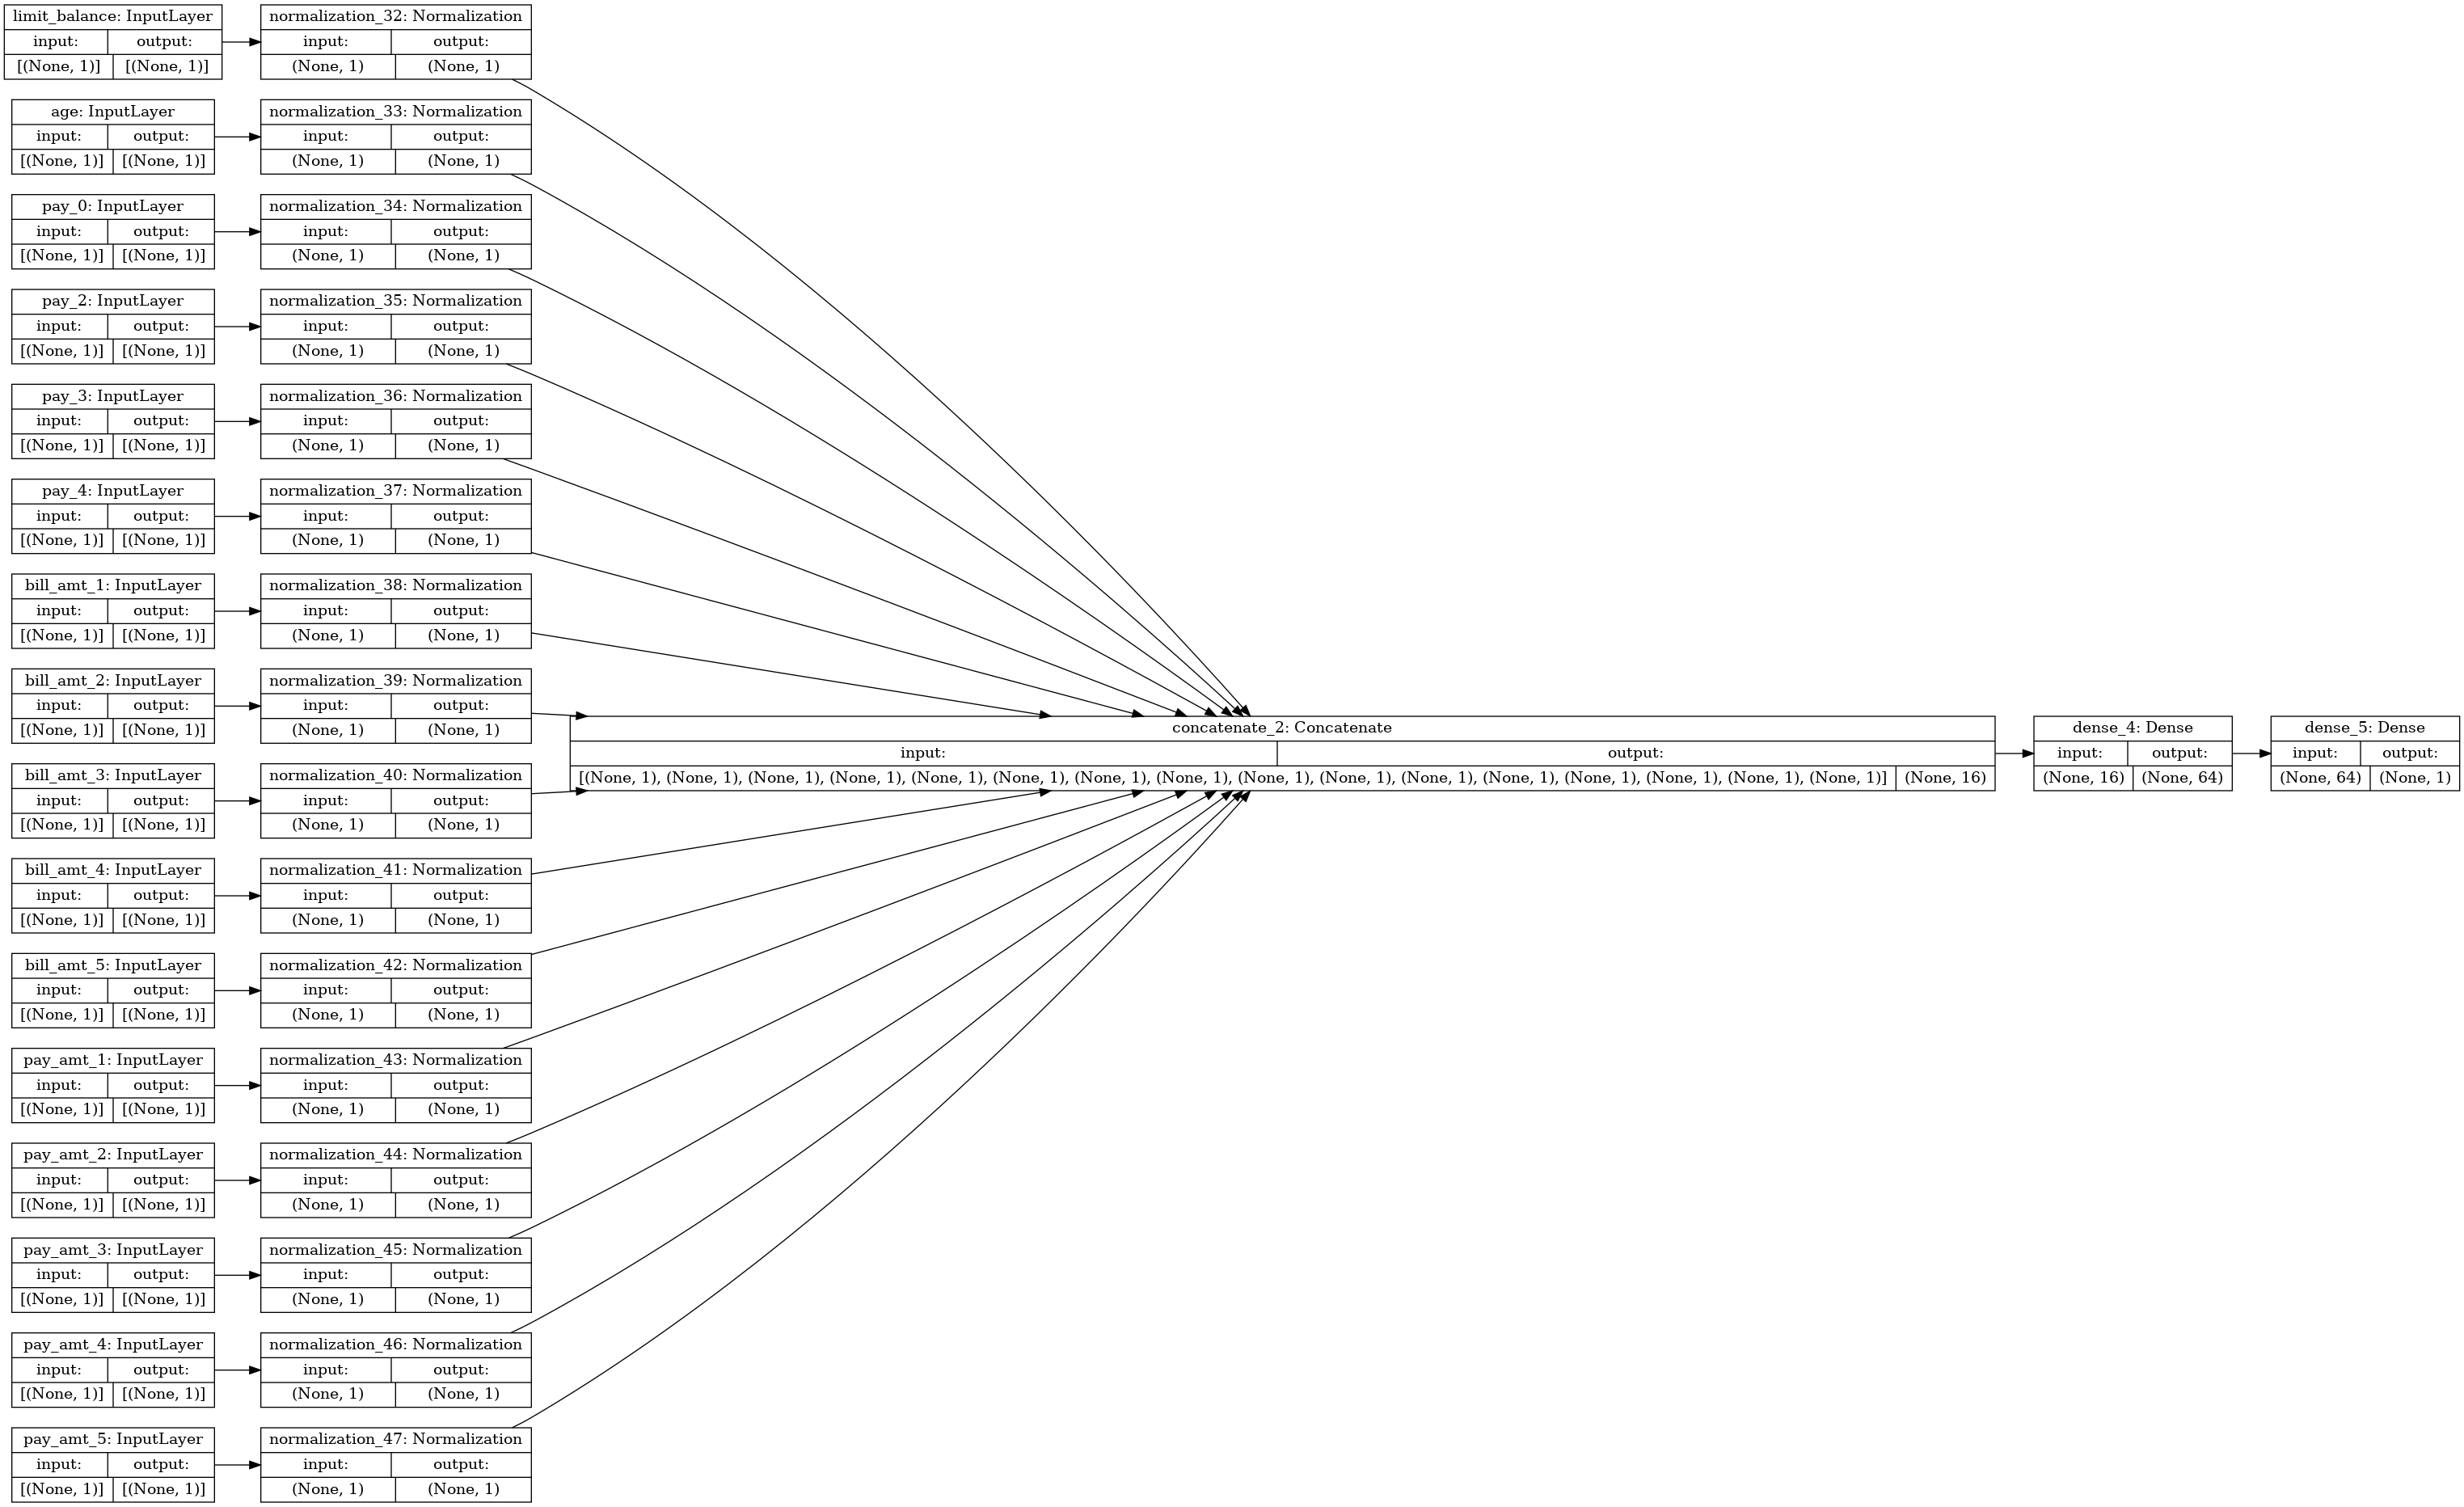

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


# Training the TensorFlow Model using the training data and the validation dataset

In [55]:
model.fit(train_data, validation_data = val_data, epochs = 20)


Epoch 1/20
88/88 [==============================] - 1s 4ms/step - loss: 0.1012 - val_loss: 0.0949
Epoch 2/20
88/88 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0623
Epoch 3/20
88/88 [==============================] - 0s 3ms/step - loss: 0.0688 - val_loss: 0.0569
Epoch 4/20
88/88 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0591
Epoch 5/20
88/88 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0553
Epoch 6/20
88/88 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0575
Epoch 7/20
88/88 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0549
Epoch 8/20
88/88 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0539
Epoch 9/20
88/88 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0576
Epoch 10/20
88/88 [==============================] - 0s 3ms/step - loss: 0.0616 - val_loss: 0.0593
Epoch 11/20
88/88 [